In [1]:
import numpy as np

from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Simulation run')

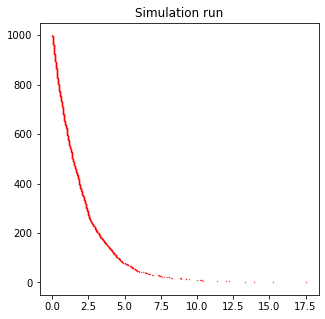

In [2]:
class Gillespie:
    
    def __init__(self, X, C, delta_X, H):
        self.X = np.asarray(X, dtype=int)
        self.C = np.asarray(C)
        self.delta_X = np.asarray(delta_X, dtype=int)
        self.H = H

    @staticmethod
    def calc_av(X, H, C):
        """Calculate the Av value.
        The number of available permutations multiplied be the rates."""
        return [h(X) * C for h in H]
        # return X @ H.T * C
    
    @staticmethod
    def calc_tau(a0, rv):
        """Calculate the Tau value, which is the probable length of time
        before any given simulated reaction occurs."""
        return (1 / a0) * np.log(1 / rv)
    
    @staticmethod
    def calc_mu(av, a0, rv):
        """Calculate the mu value.
        
        :param Av_vals:
            The possible reaction permutations * their rates. Given
            as a numpy array.
        :param Av_sum:
            The sum of the `Av_vals` array. This sum is used in
            multiple places, so it is not calculated within this
            function.
        :param random_value:
            A randomly generated value between zero and one.
        :returns mu:
            The index corresponding to the reaction that should be
            simulated.
            
        Essentially we generate blocks of value on a number line
        from zero to one. A random number determines where on this
        line a reaction "occurs".
            [================================================]
            0.0                  *                          1.0
                                  A random point.
                                  
        We cast the possible reactions to this scale by multiplying
        the random value by the sum of Av values. Such casting is
        done by chunks.
            [================================================]
            [=Chunk 1=][======Chunk 2======][=====Chunk 3====]
            
        The sums of these chunks are examined, and when the sum is 
        found to be greater than the randomly cast point defined above, 
        the corresponding reaction is simulated.
        
        ..warning::
            A different random value should be used for `calc_mu()` and
            `calc_tau()`.
        """
        return np.argwhere(np.cumsum(av) > (rv * a0)).flatten()[0]
    
    def simulate(self, max_iter=1000, max_time=1000):
        """Runs a stochastic simulation based on the input provided."""
        curr_time = 0
        curr_iter = 0
        
        t_out = np.empty((max_iter))
        x_out = np.empty((max_iter, self.X.shape[0]))
        
        t_out[0] = curr_time
        x_out[0] = self.X.copy()
        
        while (curr_iter < max_iter) and (curr_time < max_time):
            av = self.calc_av(self.X, self.H, self.C)
            # print(av)
            a0 = np.sum(av)
            rv1, rv2 = rng.random(2)
            tau = self.calc_tau(a0, rv1)
            mu = self.calc_mu(av, a0, rv2)
            self.X += self.delta_X[mu]
            curr_time += tau
            t_out[curr_iter] = curr_time
            x_out[curr_iter] = self.X
            curr_iter += 1
                        
        return t_out, x_out
    
    
    
    
lotka_params = dict(
    X=[1000, 1000],
    C=[10, 0.01, 10],
    delta_X=[[1, 0], [-1, 1], [0, -1]],
    H=[lambda x: x, lambda x: x[0] * (x[0] - 1) / 2]
)

exp_decay_params = dict(
    X=[1000],
    C=[0.5],
    delta_X=[[-1]],
    H=[lambda x: x]
)

gill = Gillespie(**exp_decay_params)
times, x_vals = gill.simulate()

plt.figure(1, figsize=(5,5))
plt.scatter(times, x_vals, marker=".", s=.5, alpha=0.9, color = 'r')
plt.title("Simulation run")

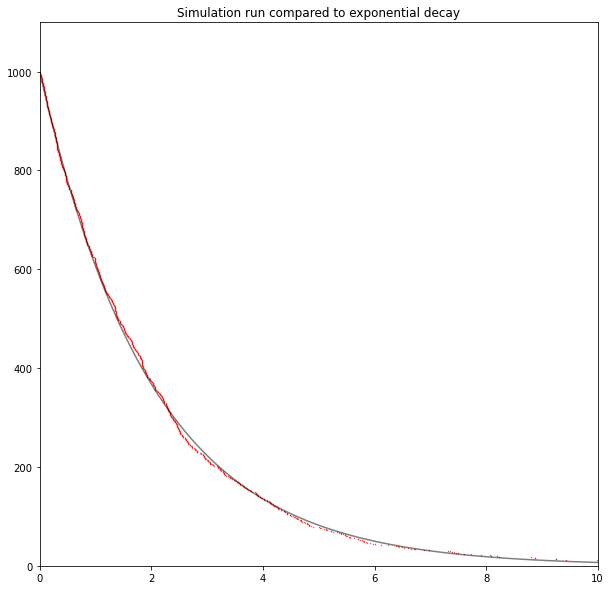

In [3]:
def exponential_decay(X, c, t):
    return X * np.exp(-c * t)

time_range = np.linspace(0, 10, 1000)

exp = exponential_decay(1000, 0.5, time_range)





plt.figure(2, figsize=(10,10))
plt.title("Simulation run compared to exponential decay")

plt.xlim(0, time_range[-1])
plt.ylim(0, 1100)

plt.scatter(times, x_vals, marker=".", s=.5, alpha=0.9, color = 'r')
plt.plot(time_range, exp, 'k', alpha=0.5, linewidth=1.5)

In [78]:
exp_runs = [Gillespie(**exp_decay_params).simulate() for i in range(100)]

In [83]:
# run[1]

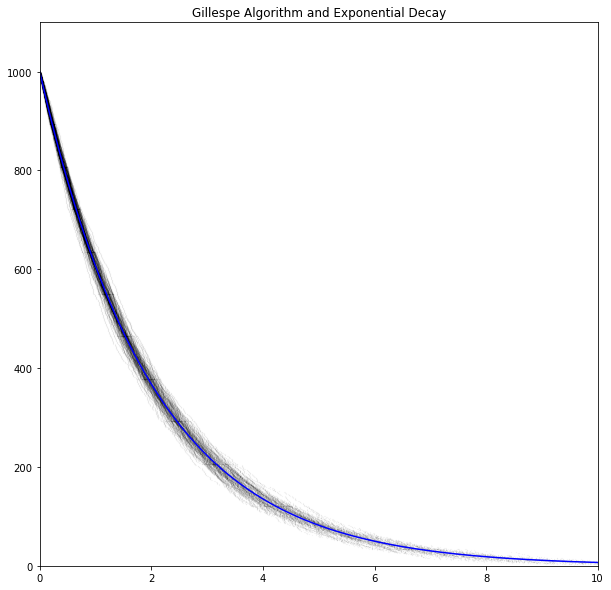

In [84]:
plt.figure(3, figsize=(10,10))
plt.ylim(0, 1100)
plt.xlim(0,10)
# Plot the exp decay function, so we can compare
plt.plot(time_range, exp, 'b', linewidth=1.5)

# for every item (run) in the list exp_runs
for run in exp_runs:
    t, x = run
    plt.scatter(t, x, marker=".", s=.1, alpha=0.1, color='k')
    
plt.title('Gillespe Algorithm and Exponential Decay')

In [ ]:
# with the same variable descriptions as in the exp function.
# use more () instead of [], python treats those differently.
def rms_exp(X, c, t):
    return (X * np.exp(-c*t)*(1 - np.exp(-c*t)))**(0.5)
